In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
sns.set()

from nltk.corpus import stopwords as nltk_stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


import pickle
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.txt',sep=';',names=['text','emotion'])
df_val = pd.read_csv('val.txt',sep=';',names=['text','emotion'])

In [5]:
df

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


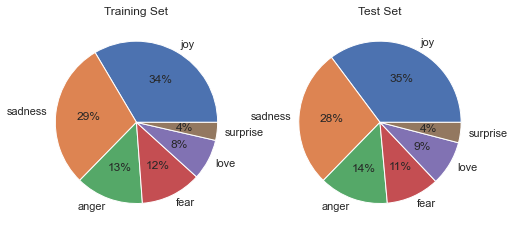

In [14]:
fig,ax = plt.subplots(1,2,figsize=(8,20))
ax[0].pie(df['emotion'].value_counts(),labels=df['emotion'].value_counts().index,autopct='%1.0f%%')
ax[0].set_title("Training Set")
ax[1].pie(df_val['emotion'].value_counts(),labels=df_val['emotion'].value_counts().index,autopct='%1.0f%%')
ax[1].set_title("Test Set")
plt.show()

In [4]:
df['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [15]:
df_val['emotion'].value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64

In [6]:
df.shape, df_val.shape

((16000, 2), (2000, 2))

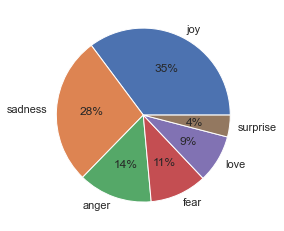

In [7]:
fig,ax = plt.subplots()
ax.pie(df_val['emotion'].value_counts(),labels=df_val['emotion'].value_counts().index,autopct='%1.0f%%')
plt.show()

Some of the categories are under-represented. I might need to boost their numbers by up-sampling them during training.<br>
This dataset has a different validation dataset. I'll use that dataset as my test set. I'll make a validation set from the training dataset. Let's look at the distribution of classes in the validation dataset.

## Analysis of Data

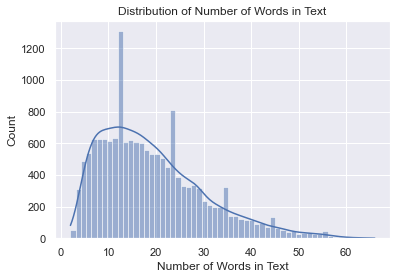

In [16]:
sns.histplot(df['text'].apply(str.split).apply(len),kde=True)
plt.xlabel('Number of Words in Text')
plt.title('Distribution of Number of Words in Text')
plt.show()

#### Word Clouds

When I plotted wordclouds with default spacy stopwords, the words: feel, like, feeling were top 5 in all the categories. I'm going to add them to the stopwords. I've also notice words like im and ive, which should be in stopwords too.

In [17]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = list(nlp.Defaults.stop_words)
#NOTE: I will probably pickle nlp
spacy_stopwords.append('feel')
spacy_stopwords.append('like')
spacy_stopwords.append('feeling')
spacy_stopwords.append('im')
spacy_stopwords.append('ive')

In [18]:
#adding single characters to stopwords
for i in string.ascii_lowercase:
    if i not in spacy_stopwords:
        spacy_stopwords.append(i)
#NOTE: this list of stopwords needs to be pickled

In [19]:
#this functions gives the corpus in a list. This corpus includes repeated words to help generate the wordclouds
def getcorpus(df):
    corpus = ''
    for item in df:
        for word in item.split():
            corpus += (' '+word)
    return corpus

In [20]:
#generating wordclouds by categories in emotion
wordcloud=[]
for emotion in df['emotion'].unique():
    wordCloud = WordCloud(background_color='white',
                          stopwords=spacy_stopwords,
                          width=2000,
                          height=2500,
                          max_words=50,
                          random_state=2)
    wordcloud.append(wordCloud.generate(getcorpus(df['text'].loc[df['emotion']==emotion])))

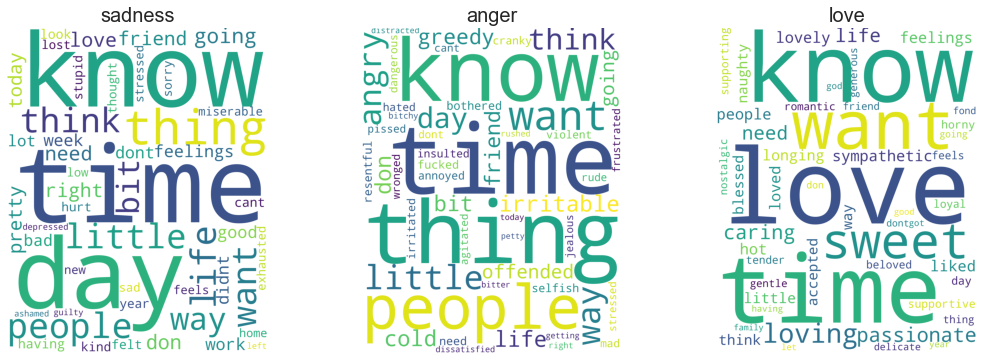

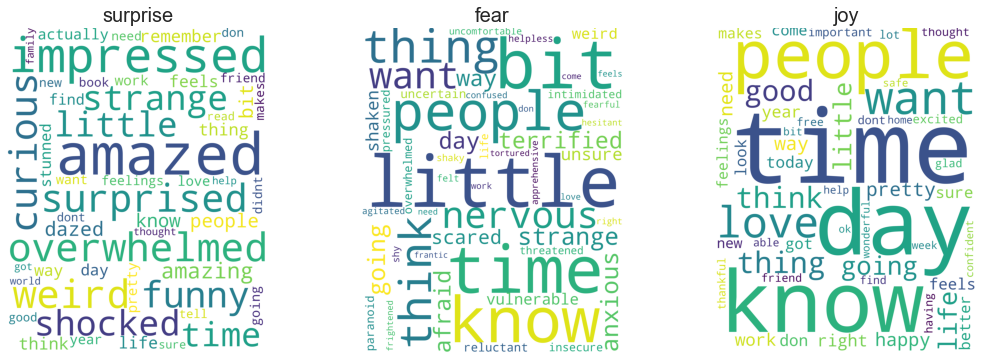

In [21]:
#Plotting wordclouds by categories in emotion
emotions = df['emotion'].unique()
fig, ax = plt.subplots(1,3,figsize=(18,6))
for i in [0,1,2]:
    ax[i].imshow(wordcloud[i])
    ax[i].axis('off')
    ax[i].set_title(emotions[i],fontsize=20)
plt.show()

fig, ax = plt.subplots(1,3,figsize=(18,6))
for i in [3,4,5]:
    ax[i-3].imshow(wordcloud[i])
    ax[i-3].axis('off')
    ax[i-3].set_title(emotions[i],fontsize=20)
plt.show()

I feel tempted to add words like know, time, day, thing, think in the stopwords, because I think they have nothing to do with the sentiment of the sentence. But their distribution is different in the different categories, which might be a differentiating factor.

### Lemmatization

When I lemmatized, removed stop-words and tokenized the texts, I noticed some single characters remaining, like t and m, which are probably coming from apostrophe words like don't and I'm. I will add all single letter lower case characters to the list of stopwords.

In [22]:
#this function will lemmatize the input text
def lemmatize(s):
    return ' '.join([str(word) for word in nlp(s) if str(word.lemma_).lower() not in spacy_stopwords])
#NOTE: this function needs to be pickled

In [23]:
df['clean_text'] = df['text'].apply(lemmatize)
df_val['clean_text'] = df_val['text'].apply(lemmatize)

In [24]:
df

,text,emotion,clean_text
0,i didnt feel humiliated,sadness,humiliated
1,i can go from feeling so hopeless to so damned...,sadness,hopeless damned hopeful cares awake
2,im grabbing a minute to post i feel greedy wrong,anger,grabbing minute post greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,nostalgic fireplace know property
4,i am feeling grouchy,anger,grouchy
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,brief time beanbag anna beaten
15996,i am now turning and i feel pathetic that i am...,sadness,turning pathetic waiting tables subbing teachi...
15997,i feel strong and good overall,joy,strong good overall
15998,i feel like this was such a rude comment and i...,anger,rude comment glad


In [25]:
df_val

,text,emotion,clean_text
0,im feeling quite sad and sorry for myself but ...,sadness,sad sorry ill snap soon
1,i feel like i am still looking at a blank canv...,sadness,looking blank canvas blank pieces paper
2,i feel like a faithful servant,love,faithful servant
3,i am just feeling cranky and blue,anger,cranky blue
4,i can have for a treat or if i am feeling festive,joy,treat festive
...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,ssa examination tomorrow morning prepared comi...
1996,i constantly worry about their fight against n...,joy,constantly worry fight nature push limits inne...
1997,i feel its important to share this info for th...,joy,important share info experience thing
1998,i truly feel that if you are passionate enough...,joy,truly passionate stay true succeed


### Vectorizer

In [26]:
#vectorizer for input text
vectorizer = TfidfVectorizer(stop_words=spacy_stopwords)
vectorizer.fit(df['clean_text'])
X_train = vectorizer.transform(df['clean_text']).todense()
X_test = vectorizer.transform(df_val['clean_text']).todense()
#Pickle vectorizer

In [27]:
y_train = df['emotion']
y_test = df_val['emotion']

### Training Some Models

In [28]:
classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),
               LGBMClassifier()]

scores = pd.DataFrame(columns=['Classifier','Test-Accuracy','Train-Accuracy','Test-ROC-AUC','Train-ROC-AUC','Test-CM','Train-CM'])

for i in classifiers:
    t0 = time.time()
    i.fit(X_train,y_train)
    t1 = time.time()
    print(i.__class__.__name__)
    print('Training complete. Time taken {}min {}sec'.format(int((t1-t0)/60),(t1-t0)%60))
    print()
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    y_pred_prob_test = i.predict_proba(X_test)
    y_pred_prob_train = i.predict_proba(X_train)
    
    scores.loc[scores.shape[0]] = [i.__class__.__name__, accuracy_score(y_test,y_pred_test),accuracy_score(y_train,y_pred_train),
                                   roc_auc_score(y_test,y_pred_prob_test,multi_class='ovr'),roc_auc_score(y_train,y_pred_prob_train,multi_class='ovr'),
                                   confusion_matrix(y_test,y_pred_test,normalize='true'),confusion_matrix(y_train,y_pred_train,normalize='true')]

DecisionTreeClassifier
Training complete. Time taken 8min 38.167346239089966sec

RandomForestClassifier
Training complete. Time taken 4min 25.697089433670044sec

LGBMClassifier
Training complete. Time taken 0min 3.8553714752197266sec



In [29]:
scores.sort_values(by='Test-Accuracy',inplace=True)
scores.drop(['Test-CM','Train-CM'],axis=1)

,Classifier,Test-Accuracy,Train-Accuracy,Test-ROC-AUC,Train-ROC-AUC
0,DecisionTreeClassifier,0.8625,0.996313,0.910820,0.999992
2,LGBMClassifier,0.8810,0.943875,0.986029,0.997180
1,RandomForestClassifier,0.8940,0.996313,0.987763,0.999974


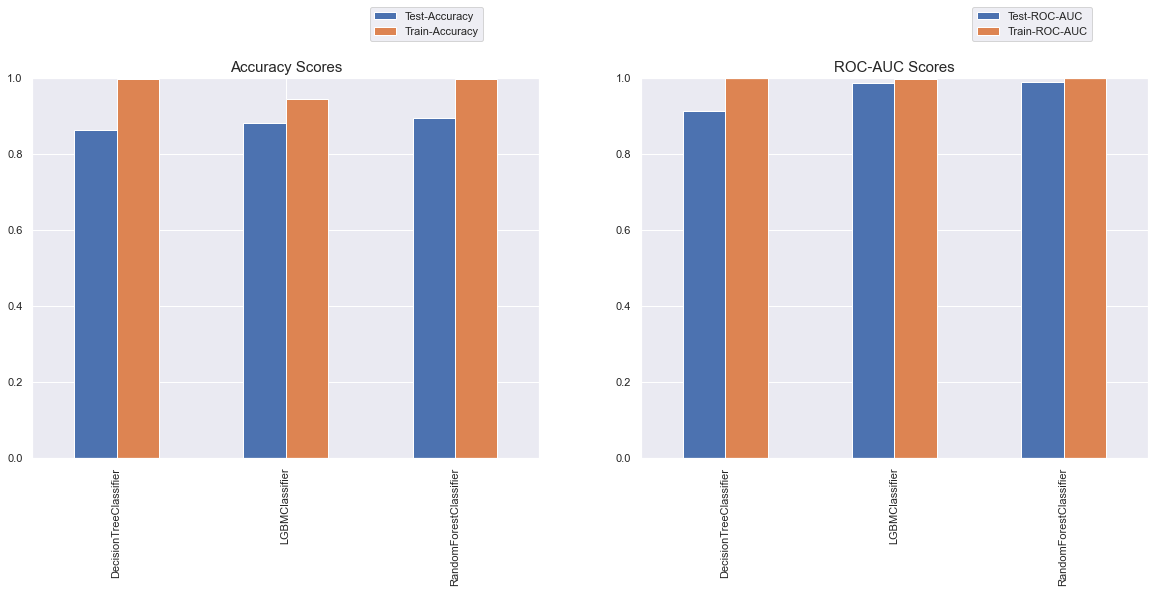

In [30]:
fig, ax = plt.subplots(1,2,figsize=(20,7))
scores.plot.bar(x='Classifier',y=['Test-Accuracy','Train-Accuracy'],ax=ax[0])
ax[0].set_ylim(0,1)
ax[0].set_xlabel(None)
ax[0].legend(bbox_to_anchor=(0.9,1.2))
ax[0].set_title('Accuracy Scores',fontsize=15)

scores.plot.bar(x='Classifier',y=['Test-ROC-AUC','Train-ROC-AUC'],ax=ax[1])
ax[1].set_ylim(0,1)
ax[1].legend(bbox_to_anchor=(0.9,1.2))
ax[1].set_xlabel(None)
ax[1].set_title('ROC-AUC Scores',fontsize=15)
plt.show()

DecisionTreeClassifier


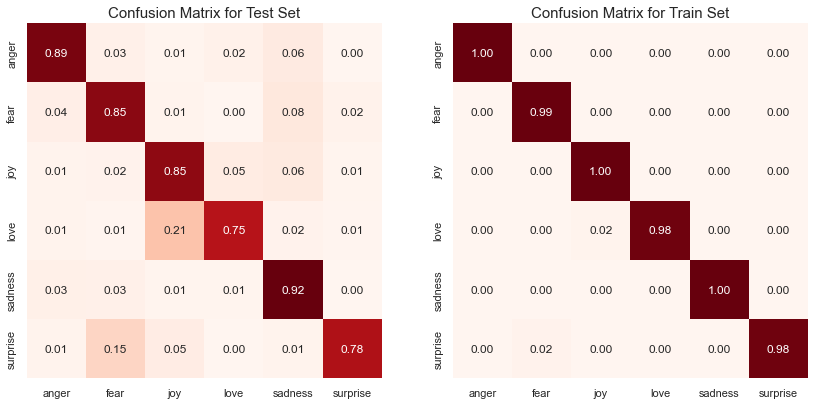

   LGBMClassifier   


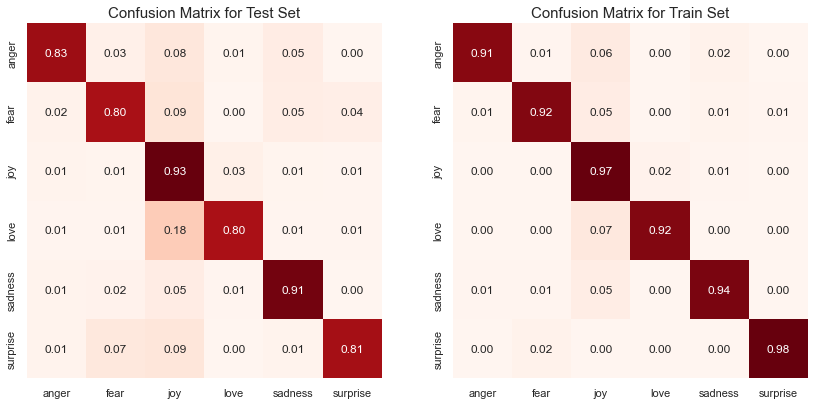

RandomForestClassifier


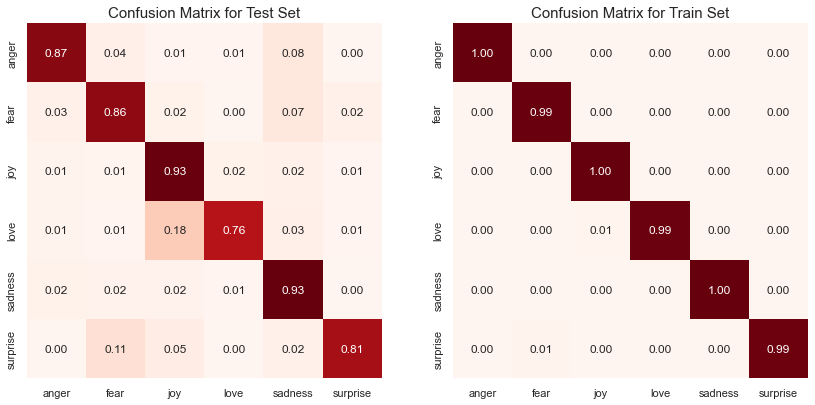

In [31]:
classes = classifiers[0].classes_
for i in scores.index:
    print(scores['Classifier'].loc[i].center(20))
    fig, ax = plt.subplots(1,2,figsize=(14,28))
    sns.heatmap(scores['Test-CM'].loc[i],cmap='Reds',annot=True,square=True,cbar=False,
                ax=ax[0],fmt='0.2f',xticklabels=classes,yticklabels=classes)
    ax[0].set_title("Confusion Matrix for Test Set",fontsize=15)
    sns.heatmap(scores['Train-CM'].loc[i],cmap='Reds',annot=True,square=True,cbar=False,
                ax=ax[1],fmt='0.2f',xticklabels=classes,yticklabels=classes)
    ax[1].set_title("Confusion Matrix for Train Set",fontsize=15)
    plt.show()

### Final Model

I will pick the LightGBM Classifier - very good performance wrt recall scores, and you cannot beat that training time. Very impressive.

In [38]:
model = classifiers[2]#Use LGBM for final model. It classifies the minority classes the best

In [40]:
pickle.dump(spacy_stopwords,open('model_spacy_stopwords.pkl','wb')) 
pickle.dump(nlp,open('model_spacy_nlp.pkl','wb'))
pickle.dump(vectorizer,open('model_vectorizer.pkl','wb'))
pickle.dump(model,open('model_lgbm_classifier.pkl','wb'))

In [43]:
sentence = ("I am very glad at my promotion")
sentence_prediction(sentence)

'There is a 90.35% chance you feel joy'

In [41]:
#this function returns top 2 predicted classes and their probabilities by the classifier passed, of the sentence
def sentence_prediction(sentence):
    y_predict_proba = model.predict_proba(vectorizer.transform([lemmatize(sentence)]).todense())[0]
    args = np.flip(np.argsort(y_predict_proba))
    emotion_pred = classes[args]
    prob_pred = np.flip(np.sort(y_predict_proba))
    if(prob_pred[0]>0.9):
        prediction = "There is a {:.2f}% chance you feel {}".format(prob_pred[0]*100,emotion_pred[0])
    else:
        prediction="There is a {:.2f}% chance you feel {} and a {:.2f}% chance you feel {}".format(prob_pred[0]*100,emotion_pred[0],
                                                                                         prob_pred[1]*100,emotion_pred[1])
    return prediction